# Boulder Analysis 

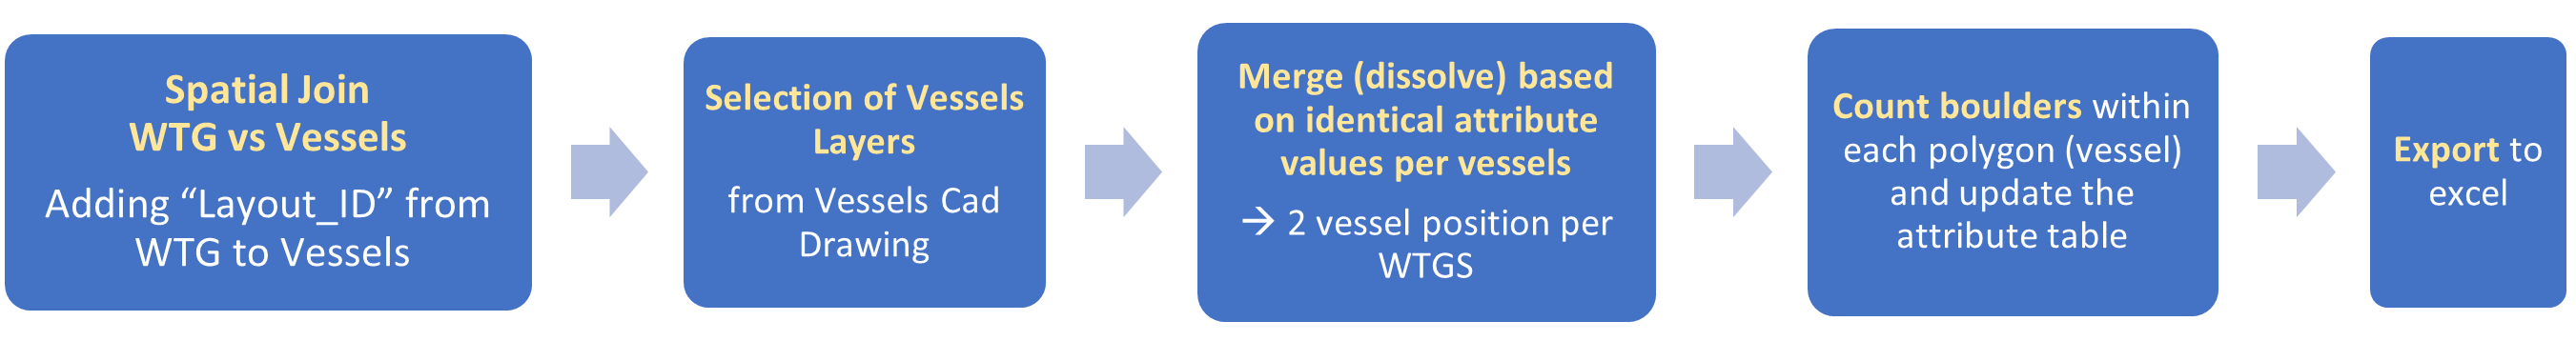

# Inputs 

In [8]:
import arcpy
import os
import shutil

# Define the input shapefile paths
bol = r"\\WM20ocqu46ph01\WF_Projects\DK_THO\4_OUTPUT\VESSELS\20240709_Boulder_Analysis_Vessels_Dens\Input\EAC Boulders 2023.shp"
wtg = r"\\WM20ocqu46ph01\WF_Projects\DK_THO\4_OUTPUT\VESSELS\20240709_Boulder_Analysis_Vessels_Dens\Input\DK_THO_Layout_pt_UTM32N_v3.shp"
vessels = r"\\WM20ocqu46ph01\WF_Projects\DK_THO\4_OUTPUT\VESSELS\20240718_Boulder_Analysis_Vessels_Dens\Inputs\Vessels_All.shp"

# Define the output folder
folder = r"\\WM20ocqu46ph01\WF_Projects\DK_THO\4_OUTPUT\VESSELS\20240718_Boulder_Analysis_Vessels_Dens\Output_Together"

# Vessels name selected from the CAD drawing
vessels_names = ["Defpoints", 'FOWIC - Vessel - Ghost']

# Fields between 
fields_keep_in_outputs = ["Layer", "Layout_ID"]


### Delete previously created files in the output folder

In [9]:
# Function to delete all files in the specified folder
def delete_all_files_in_folder(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')
            
delete_all_files_in_folder(folder)

# The workflow of analysis

### Perform a Spatial Join (WTG vs Vessels) and Adding “Layout_ID” from WTG to Vessels


In [11]:
# Perform a spatial join to add Layout_ID from wtg to vessels based on nearest
output_vessels_joined = os.path.join(folder, "Vessels_Joined.shp")

arcpy.analysis.SpatialJoin(target_features=vessels,
                           join_features=wtg,
                           out_feature_class=output_vessels_joined,
                           join_type="KEEP_ALL",
                           match_option="CLOSEST",
                           search_radius=None,
                           distance_field_name="Distance")

# Function to delete all fields except the specified fields
def delete_all_fields_except(shapefile, keep_fields):
    fields = arcpy.ListFields(shapefile)
    fields_to_delete = [field.name for field in fields if field.name not in keep_fields and field.type not in ('OID', 'Geometry')]
    if fields_to_delete:
        arcpy.DeleteField_management(shapefile, fields_to_delete)

# Clean up fields and add "Layout_ID" from the join and "Layer" from the original vessels shapefile
delete_all_fields_except(output_vessels_joined, fields_keep_in_outputs)

### Select Vessels from Vessels Cad Drawing =  All legs Together


In [12]:
# Define the output shapefile paths
output_1 = os.path.join(folder, "vessels_only.shp")

# Make feature layers
vessels_layer = "vessels_layer"
arcpy.MakeFeatureLayer_management(output_vessels_joined, vessels_layer)

# Select "Vessel" features
arcpy.SelectLayerByAttribute_management(vessels_layer, "NEW_SELECTION", f"{fields_keep_in_outputs[0]} = '{vessels_names[0]}' or {fields_keep_in_outputs[0]} = '{vessels_names[1]}'")
arcpy.CopyFeatures_management(vessels_layer, output_1)

<Result '\\\\WM20ocqu46ph01\\WF_Projects\\DK_THO\\4_OUTPUT\\VESSELS\\20240718_Boulder_Analysis_Vessels_Dens\\Output_Together\\vessels_only.shp'>

### To merge (dissolve) based on identical attribute values for each vessel  (2 vessel position per WTGS), 

In [13]:
output_1_dissolve = os.path.join(folder, "vessels_dissolve.shp")

# Fields to use for merging geometries (must be identical for features to merge)
merge_fields = ["Layout_ID"]

# Perform the merge (dissolve) based on identical attribute values
arcpy.management.Dissolve(output_1, output_1_dissolve, dissolve_field=merge_fields)


<Result '\\\\WM20ocqu46ph01\\WF_Projects\\DK_THO\\4_OUTPUT\\VESSELS\\20240718_Boulder_Analysis_Vessels_Dens\\Output_Together\\vessels_dissolve.shp'>

### Count boulders within each polygon (vessel) and update the attribute table

In [14]:
# Function to add a new field to a shapefile
def add_field(shapefile, field_name, field_type):
    if not arcpy.ListFields(shapefile, field_name):
        arcpy.AddField_management(shapefile, field_name, field_type)

# Function to calculate point counts within polygons and update attribute table
def calculate_point_counts(polygons_shapefile, points_shapefile, count_field):
    # Create a dictionary to store Layout_ID counts
    layout_id_counts = {}

    # Use SearchCursor to iterate through polygons and count points within each Layout_ID
    with arcpy.da.SearchCursor(polygons_shapefile, ["OID@", "Shape@", "Layout_ID"]) as poly_cursor:
        for poly_row in poly_cursor:
            poly_id = poly_row[0]
            poly_geometry = poly_row[1]
            layout_id = poly_row[2]
            if layout_id not in layout_id_counts:
                layout_id_counts[layout_id] = 0

            # Use SearchCursor to count points within current polygon
            with arcpy.da.SearchCursor(points_shapefile, ["OID@", "Shape@"], spatial_reference=poly_geometry.spatialReference) as point_cursor:
                for point_row in point_cursor:
                    point_id = point_row[0]
                    point_geometry = point_row[1]

                    if poly_geometry.contains(point_geometry):
                        layout_id_counts[layout_id] += 1

    # Update the attribute table in polygons_shapefile with counts
    with arcpy.da.UpdateCursor(polygons_shapefile, ["Layout_ID", count_field]) as update_cursor:
        for update_row in update_cursor:
            layout_id = update_row[0]
            if layout_id in layout_id_counts:
                update_row[1] = layout_id_counts[layout_id]
                update_cursor.updateRow(update_row)

# Ensure both shapefiles have a "Boulder_count" field
add_field(output_1_dissolve, "Boulder", "LONG")

# Calculate point counts within polygons for each shapefile
calculate_point_counts(output_1_dissolve, bol, "Boulder")

print("Point count calculation completed successfully.")


Point count calculation completed successfully.


## Export to tables

In [15]:
table_1 = os.path.join(folder,"All.xlsx")

# Export the attribute table of the shapefile to Excel format
arcpy.TableToExcel_conversion(output_1_dissolve, table_1)

print("Shapefiles exported to tables successfully.")


Shapefiles exported to tables successfully.
